In [1]:
import emcee
from matplotlib import pyplot as plt
import numpy as np
from sample import sample

# initialize object of class 'sample'

In [2]:
dir_corr = './corr/'
dir_cov = './cov/'

fname_wgg = dir_corr + 'wgg.csv'
fname_wgp = dir_corr + 'wgp.csv'

fname_wgg_cov = dir_cov + 'cov_wgg.txt'
fname_wgp_cov = dir_cov + 'cov_wgp.txt'

suffix_smp = 'test'

In [3]:
z_fit = 0.45
rfit_min, rfit_max = 2,40

In [4]:
smp = sample(fname_wgg, fname_wgg_cov, fname_wgp, fname_wgp_cov, suffix_smp, z_fit, rfit_min, rfit_max)

# read data

In [5]:
smp.read_wgg()
smp.read_wgp()

### plot $w_{gg}$

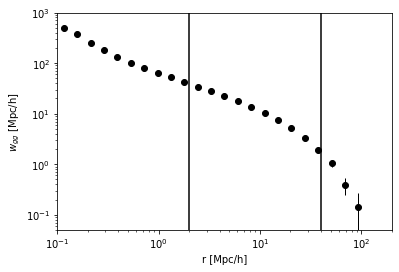

In [6]:
plt.errorbar(smp.wgg.rp, smp.wgg.wgg, yerr = smp.wgg.wggerr, c='k', label = 'sim.', ls='none', lw=1, marker='o')

plt.xlim(0.1,200)
plt.ylim(0.05,1000)

plt.axvline(x=smp.rfit_min, c='k')
plt.axvline(x=smp.rfit_max, c='k')

plt.xlabel('r [Mpc/h]')
plt.ylabel('$w_{gg}$ [Mpc/h]')

plt.loglog()
plt.show()

### plot $w_{g+}$

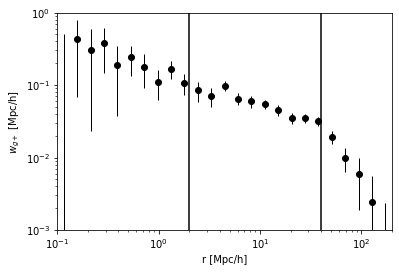

In [7]:
plt.errorbar(smp.wgp.rp, smp.wgp.wgp, yerr = smp.wgp.wgperr, c='k', label = 'sim.', ls='none', lw=1, marker='o')

plt.xlim(0.1,200)
plt.ylim(0.001,1)

plt.axvline(x=smp.rfit_min, c='k')
plt.axvline(x=smp.rfit_max, c='k')

plt.xlabel('r [Mpc/h]')
plt.ylabel('$w_{g+}$ [Mpc/h]')

plt.loglog()
plt.show()

# run mcmc

### mcmc parameters for first run to get initial guess

In [8]:
reset_chain = 'True'
nstep=100
nstep_burn = 0
nstep_thin = 1
nwalkers = 8
ncore = 2

rfit_min, rfit_max = 2,50

### initial guess

In [9]:
p_linbias_ini = 1.0
p_quadbias_ini = [1.0,0.0,0.0]
p_nla_ini = 1.0
p_tatt_ini = [1.0,0.0,0.0]

### fit wgg with linear bias model

In [10]:
smp.run_mcmc_wgg(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'linbias', p_linbias_ini)

### fit wgg with quadratic bias model

In [11]:
smp.run_mcmc_wgg(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'quadbias',p_quadbias_ini)

### fit wgp with NLA model
- using best fit linear bias from wgg

In [12]:
p_bias = np.array([smp.p_linbias_maxL[0],0,0])

In [13]:
smp.run_mcmc_wgp(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'nla',p_nla_ini, p_bias)

### fit wgp with TATT model
- using best fit linear bias from wgg

In [14]:
smp.run_mcmc_wgp(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'tatt',p_tatt_ini, p_bias)

# read chains
- if chains already exist, you can read them directly

In [15]:
smp.chain_nla = smp._get_chain(nstep_burn, nstep_thin, smp.fname_chain_nla)
smp.chain_tatt = smp._get_chain(nstep_burn, nstep_thin, smp.fname_chain_tatt)

smp.lgP_nla = smp._get_log_prob(nstep_burn, nstep_thin, smp.fname_chain_nla)
smp.lgP_tatt = smp._get_log_prob(nstep_burn, nstep_thin, smp.fname_chain_tatt)

# plot individual chains

In [16]:
chainIDs = [0,1,2,3,4] #select which chains to plot

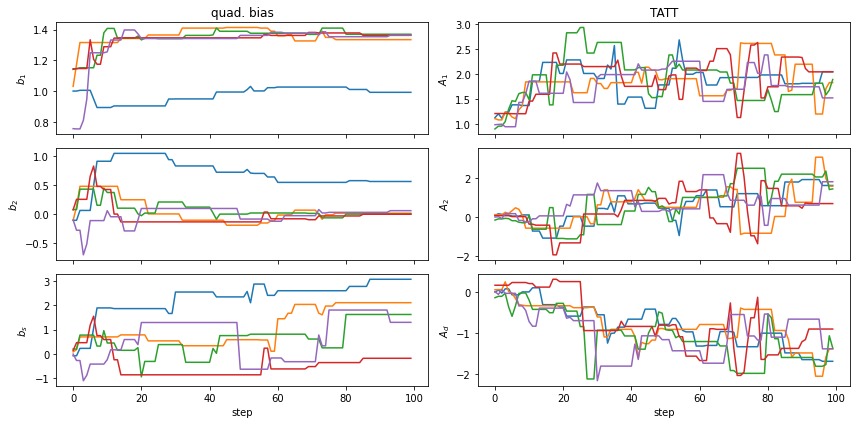

In [17]:
reader = emcee.backends.HDFBackend(smp.fname_chain_quadbias)
chain_quadbias = reader.get_chain(discard=0, thin=1, flat=False)

reader = emcee.backends.HDFBackend(smp.fname_chain_tatt)
chain_tatt = reader.get_chain(discard=0, thin=1, flat=False)


fig, ax = plt.subplots(3,2,figsize=(12,6), sharex=True)

for ID in chainIDs:
    
    ax[0,0].plot(chain_quadbias[:,ID,0])
    ax[1,0].plot(chain_quadbias[:,ID,1])
    ax[2,0].plot(chain_quadbias[:,ID,2])

    ax[0,1].plot(chain_tatt[:,ID,0])
    ax[1,1].plot(chain_tatt[:,ID,1])
    ax[2,1].plot(chain_tatt[:,ID,2])

ax[0,0].set_title('quad. bias')
ax[0,0].set_ylabel('$b_1$')
ax[1,0].set_ylabel('$b_2$')
ax[2,0].set_ylabel('$b_s$')

ax[0,1].set_title('TATT')
ax[0,1].set_ylabel('$A_1$')
ax[1,1].set_ylabel('$A_2$')
ax[2,1].set_ylabel('$A_d$')

ax[-1,0].set_xlabel('step')
ax[-1,1].set_xlabel('step')

plt.tight_layout()
plt.show()

## rerun chains, using best fit as initial guess

In [18]:
p_linbias_ini = smp.p_linbias_maxL[0]
p_quadbias_ini = smp.p_quadbias_maxL
p_nla_ini = smp.p_nla_maxL[0]
p_tatt_ini = smp.p_tatt_maxL

In [19]:
reset_chain = 'True'
nstep=400

### bias models

In [20]:
smp.run_mcmc_wgg(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'linbias', p_linbias_ini)

In [21]:
smp.run_mcmc_wgg(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'quadbias',p_quadbias_ini)

### IA models

In [22]:
p_bias = np.array([smp.p_linbias_maxL[0],0,0])

In [23]:
smp.run_mcmc_wgp(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'nla',p_nla_ini, p_bias)

In [24]:
smp.run_mcmc_wgp(reset_chain, nstep, nstep_burn, nstep_thin, nwalkers, ncore, rfit_min, rfit_max, 'tatt',p_tatt_ini, p_bias)

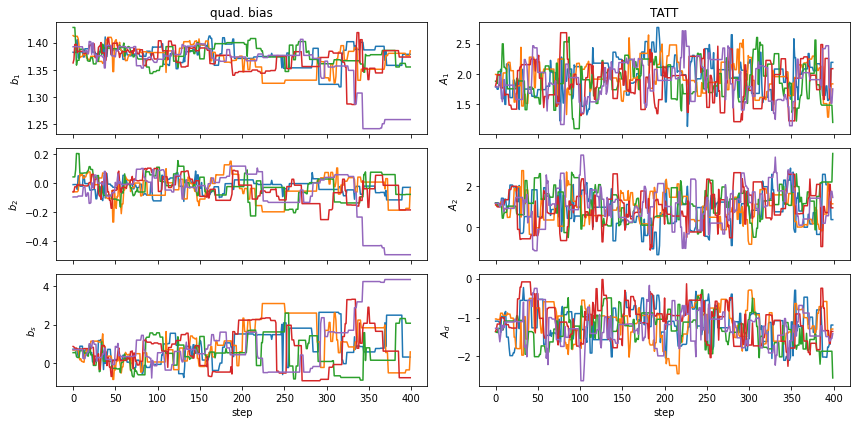

In [25]:
reader = emcee.backends.HDFBackend(smp.fname_chain_quadbias)
chain_quadbias = reader.get_chain(discard=0, thin=1, flat=False)

reader = emcee.backends.HDFBackend(smp.fname_chain_tatt)
chain_tatt = reader.get_chain(discard=0, thin=1, flat=False)


fig, ax = plt.subplots(3,2,figsize=(12,6), sharex=True)

for ID in chainIDs:
    
    ax[0,0].plot(chain_quadbias[:,ID,0])
    ax[1,0].plot(chain_quadbias[:,ID,1])
    ax[2,0].plot(chain_quadbias[:,ID,2])

    ax[0,1].plot(chain_tatt[:,ID,0])
    ax[1,1].plot(chain_tatt[:,ID,1])
    ax[2,1].plot(chain_tatt[:,ID,2])

ax[0,0].set_title('quad. bias')
ax[0,0].set_ylabel('$b_1$')
ax[1,0].set_ylabel('$b_2$')
ax[2,0].set_ylabel('$b_s$')

ax[0,1].set_title('TATT')
ax[0,1].set_ylabel('$A_1$')
ax[1,1].set_ylabel('$A_2$')
ax[2,1].set_ylabel('$A_d$')

ax[-1,0].set_xlabel('step')
ax[-1,1].set_xlabel('step')

plt.tight_layout()
plt.show()

# parameter contours

In [26]:
import pygtc

### quadratic bias model

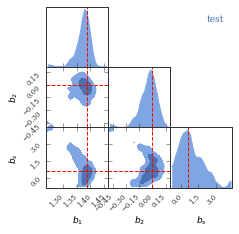

In [27]:
names = ['$b_1$','$b_2$','$b_s$']

truths = [smp.p_quadbias_maxL]

plotName = 'plots/posterior_quadbias_test.png'

labels = ['test']

GTC = pygtc.plotGTC(chains=[smp.chain_quadbias],
                    chainLabels = labels,
                    truths = truths,
                    truthColors = ['r'],
                    paramNames=names,
                    figureSize='MNRAS_column',
                    customLabelFont = {'family':'serif', 'size':9},
                    customLegendFont = {'family':'serif', 'size':9},
                    customTickFont = {'family':'serif', 'size':7},
                    colorsOrder = ['blues_old'],
                    #colorsOrder = ['blues', 'reds', 'greens', 'oranges'],
                    smoothingKernel=1.00,
                    filledPlots=True,
                    #paramRanges = paramRanges,
                    plotName=plotName)

### plot parameter contours for tatt model

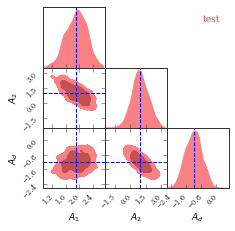

In [39]:
names = ['$A_1$','$A_2$','$A_d$']

truths = [smp.p_tatt_maxL]

plotName = 'plots/posterior_tatt_test.png'

labels = ['test']

GTC = pygtc.plotGTC(chains=[smp.chain_tatt],
                    chainLabels = labels,
                    truths = truths,
                    truthColors = ['b'],
                    paramNames=names,
                    figureSize='MNRAS_column',
                    customLabelFont = {'family':'serif', 'size':9},
                    customLegendFont = {'family':'serif', 'size':9},
                    customTickFont = {'family':'serif', 'size':7},
                    colorsOrder = ['reds_old'],
                    #colorsOrder = ['blues', 'reds', 'greens', 'oranges'],
                    smoothingKernel=1.00,
                    filledPlots=True,
                    #paramRanges = paramRanges,
                    plotName=plotName)

### compare b1 from quadratic and linear bias model fits to $w_{gg}$

Text(0, 0.5, '$P$')

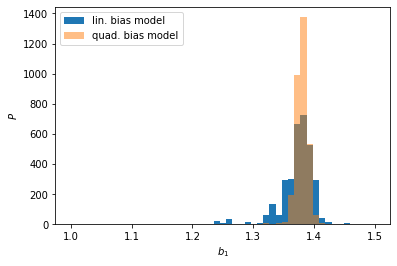

In [29]:
b1_bins = np.linspace(1,1.5,50)

plt.hist(smp.chain_quadbias[:,0], bins = b1_bins, label = 'lin. bias model')
plt.hist(smp.chain_linbias, bins = b1_bins, alpha=0.5, label = 'quad. bias model')

plt.legend()
plt.xlabel('$b_1$')
plt.ylabel('$P$')

### compare A1 from NLA and TATT model fits to $w_{g+}$

Text(0, 0.5, '$P$')

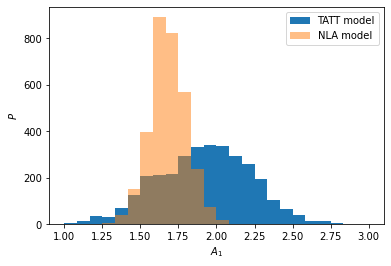

In [30]:
a1_bins = np.linspace(1,3,25)

plt.hist(smp.chain_tatt[:,0], bins=a1_bins, label = 'TATT model')
plt.hist(smp.chain_nla, bins=a1_bins, alpha=0.5, label = 'NLA model')

plt.legend()
plt.xlabel('$A_1$')
plt.ylabel('$P$')

# make predictions based on best fit parameters

In [31]:
smp.get_wgg_model('linbias')

In [32]:
smp.get_wgg_model('quadbias')

In [33]:
smp.get_wgp_model('nla')

In [34]:
smp.get_wgp_model('tatt')

# compare fits and measurements

### $w_{gg}$

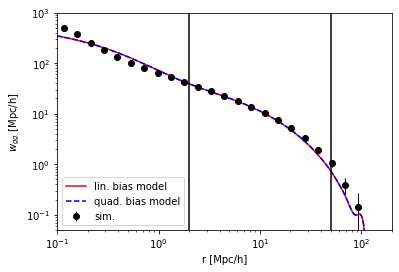

In [38]:
plt.errorbar(smp.wgg.rp, smp.wgg.wgg, yerr = smp.wgg.wggerr, c='k', label = 'sim.', ls='none', lw=1, marker='o')
plt.plot(smp.r_model, smp.wgg_linbias, c='r', ls='-', label='lin. bias model')
plt.plot(smp.r_model, smp.wgg_quadbias, c='b', ls='--', label='quad. bias model')

plt.legend()

plt.xlim(0.1,200)
plt.ylim(0.05,1000)

plt.axvline(x=smp.rfit_min, c='k')
plt.axvline(x=smp.rfit_max, c='k')

plt.xlabel('r [Mpc/h]')
plt.ylabel('$w_{gg}$ [Mpc/h]')

plt.loglog()
plt.show()

### $w_{g+}$

[]

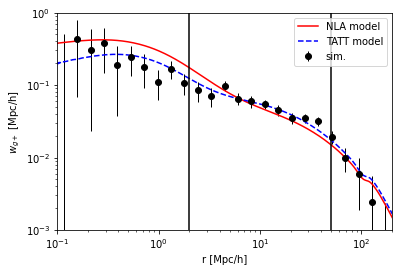

In [36]:
plt.errorbar(smp.wgp.rp, smp.wgp.wgp, yerr = smp.wgp.wgperr, c='k', label = 'sim.', ls='none', lw=1, marker='o')
plt.plot(smp.r_model, smp.wgp_nla, c='r', ls='-', label='NLA model')
plt.plot(smp.r_model, smp.wgp_tatt, c='b', ls='--', label='TATT model')

plt.legend(loc = 'upper right')

plt.xlim(0.1,200)
plt.ylim(0.001,1)

plt.axvline(x=smp.rfit_min, c='k')
plt.axvline(x=smp.rfit_max, c='k')

plt.xlabel('r [Mpc/h]')
plt.ylabel('$w_{g+}$ [Mpc/h]')

plt.loglog()